# Conda Environment Setup

All environment settings are written in ```environment.yml```. You can create the environment by running the following command in the terminal:

```shell
conda env create -f environment.yml
```

# Get Started

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Plot the data

Plot a line graph showing the sequence in amp_data, and a histogram of the amplitudes in this sequence. 

Include the code for your plots, with one to three sentences about anything you notice that might be important for modelling these data.

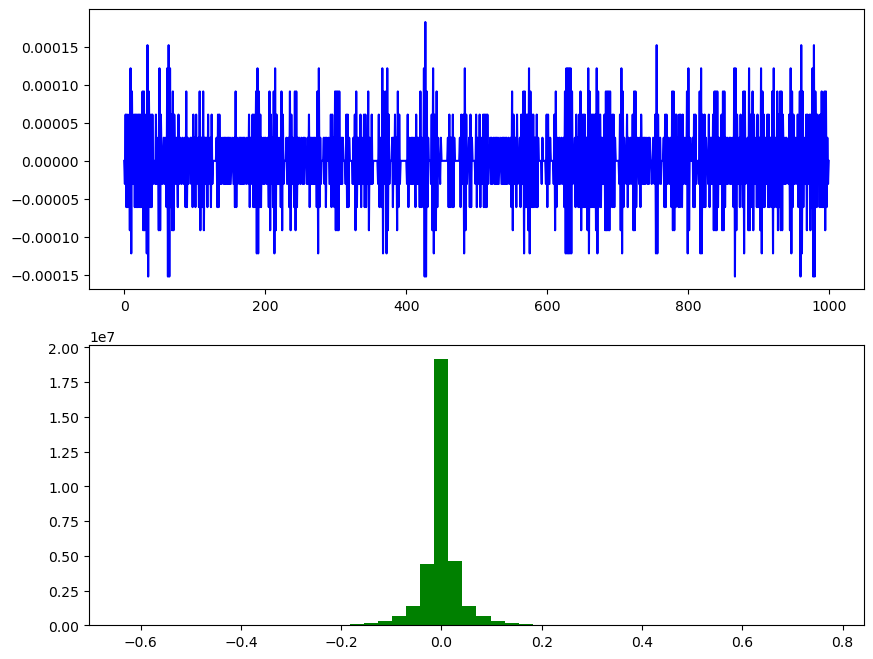

In [3]:
amp_data = np.load('amp_data.npz')['amp_data']
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Line graph of the sequence
ax1.plot(amp_data[:1000], color='blue')

# Histogram of the amplitudes
ax2.hist(amp_data, bins=50, color='green')

plt.show()

## Create dataset

Include your code for creating the six arrays above from the original amp_data array. Your answers to future questions should assume these arrays exist, rather than relisting the code from this part.

In [4]:
# Define the number of columns for reshaping (R*21 matrix)
R = 21

# Calculate how many elements we can keep for reshaping
num_rows = len(amp_data) // R

# Truncate the amp_data to fit perfectly into a matrix of shape (num_rows, R)
amp_data_truncated = amp_data[:num_rows * R]

# Reshape the data into (num_rows, 21) matrix
amp_matrix = amp_data_truncated.reshape(num_rows, R)

# Shuffle the rows of the matrix
amp_matrix_shuffled = np.random.permutation(amp_matrix)

# Split the data into training (70%), validation (15%), and testing (15%)
train_size = int(0.7 * num_rows)
val_size = int(0.15 * num_rows)

# Training data
X_shuf_train = amp_matrix_shuffled[:train_size, :-1]
y_shuf_train = amp_matrix_shuffled[:train_size, -1]

# Validation data
X_shuf_val = amp_matrix_shuffled[train_size:train_size + val_size, :-1]
y_shuf_val = amp_matrix_shuffled[train_size:train_size + val_size, -1]

# Testing data
X_shuf_test = amp_matrix_shuffled[train_size + val_size:, :-1]
y_shuf_test = amp_matrix_shuffled[train_size + val_size:, -1]

# Saving the random seed for future reproducibility
random_seed = 42

# Displaying the shapes of the created datasets
(X_shuf_train.shape, y_shuf_train.shape, X_shuf_val.shape, y_shuf_val.shape, X_shuf_test.shape, y_shuf_test.shape)

((1123775, 20), (1123775,), (240809, 20), (240809,), (240810, 20), (240810,))

# Curve fitting on a snippet of audio

Given just one row of inputs, we could fit a curve of amplitude against time through the 20 points, and extrapolate it one step into the future. Plot the points in one row of your ```X_shuf_train``` data against the numbers $t = \frac{0}{20}, ..., \frac{19}{20}$, representing times. We can fit this sequence with various linear regression models, and extrapolate them to predict the 21st time step at time $\frac{20}{20} = 1$. Indicate the point you’re predicting from ```y_shuf_train``` on the plot at $t = 1$.



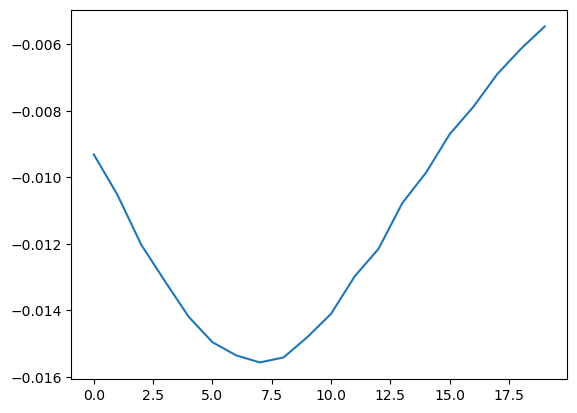

In [7]:
plt.plot(X_shuf_train[0])
plt.show()